In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

In [3]:
# load datasets
# load frequency data
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [4]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [5]:
def preprocessing(data, first_data, rx_positions, padding=True):
    data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    
    return data

In [6]:
taps = preprocessing(raw_freq_taps, raw_freq_taps, raw_rx_positions)
taps = np.hstack([np.real(taps), np.imag(taps)])

In [7]:
phi = preprocessing(raw_phi, taps, raw_rx_positions)

In [8]:
theta = preprocessing(raw_theta, taps, raw_rx_positions)

In [9]:
y  = preprocessing(raw_rx_positions, taps, raw_rx_positions, padding=False)[:,:2]

In [10]:
X = np.hstack([taps, phi[:-10], theta[:-10]])

In [11]:
#assign labels to certain areas of the map using kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=8) 
km = km.fit(y)
labels = km.predict(y)

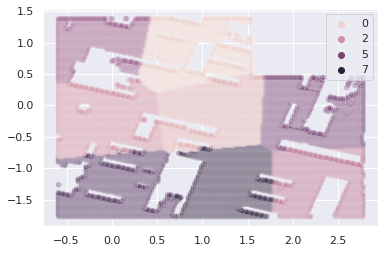

In [12]:
sns.scatterplot(y[:,0], y[:,1], hue=labels, alpha=0.3)

In [13]:
#train test split
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
train_DS = SupervisedDataset(train_X, train_labels)
test_DS = SupervisedDataset(test_X, test_labels)

In [14]:
train_loader = DataLoader(train_DS, batch_size=32)
test_loader = DataLoader(test_DS)

In [15]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=8)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Semi Supervised Learning

In [ ]:
X_sampled, X_remaining, y_sampled, y_remaining, labels_sampled, labels_remaining = train_test_split(train_X, train_y, train_labels, train_size=2500)
its = 0
while len(X_remaining)>2500:
    
    train_DS = SupervisedDataset(X_sampled, labels_sampled)
    train_loader = DataLoader(train_DS, batch_size=64, shuffle=True)
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    
    if its == 0:
        model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=8)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
    best_val_loss = 9999
    count=0
    
    for epoch in range(10):
        loss = supervised_classifier.train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = supervised_classifier.test(model, test_loader, criterion, device)
        print("Training Loss: ", loss)
        print("Validation Loss: ", val_loss)
        print("Validation Accuracy: ", val_acc)

        if best_val_loss < val_loss:
            count += 1
        else:
            best_val_loss = val_loss
        if count > 5:
            break
            
    # add confident samples to training
    
    # generate predictions for the remaining dataset
    yhats = model(torch.Tensor(X_remaining))
    #get indices for the most confident predictions
    idces = (yhats.max(dim=1).values > torch.mean(yhats.max(dim=1).values) + 2*torch.std(yhats.max(dim=1).values))
    # take the samples corresponding to those predictions and add them to the dataset
    confident_X, confident_labels, confident_y = X_remaining[idces], yhats[idces].argmax(dim=1).detach().numpy(), y_remaining[idces]
    X_sampled = np.concatenate([X_sampled, confident_X])
    y_sampled = np.concatenate([y_sampled, confident_y])
    labels_sampled = np.concatenate([labels_sampled, confident_labels])
    X_remaining, labels_remaining, y_remaining = X_remaining[~idces], labels_remaining[~idces], y_remaining[~idces]
    
    print(len(X_remaining))
    its += 1

Training Loss:  0.031651643657684324
Validation Loss:  1.8602763642107574
Validation Accuracy:  0.2668555240793201
Training Loss:  0.027639051246643065
Validation Loss:  1.6153270725607591
Validation Accuracy:  0.3620396600566572
Training Loss:  0.024663384866714478
Validation Loss:  1.486446200719594
Validation Accuracy:  0.42492917847025496
Training Loss:  0.022819480085372924
Validation Loss:  1.4159957916380854
Validation Accuracy:  0.45382436260623227
Training Loss:  0.021775760316848754
Validation Loss:  1.4225204001233895
Validation Accuracy:  0.4636449480642115
Training Loss:  0.021345651054382325
Validation Loss:  1.3231866873165252
Validation Accuracy:  0.5072710103871577
Training Loss:  0.020409248876571657
Validation Loss:  1.2839420080788766
Validation Accuracy:  0.5212464589235127
Training Loss:  0.01979260628223419
Validation Loss:  1.2286139326993541
Validation Accuracy:  0.5576959395656279
Training Loss:  0.01894489734172821
Validation Loss:  1.2595936985827116
Validat

In [ ]:
yhats = model(test_DS[:][0]).detach().argmax(dim=1)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=yhats, legend="full", palette='gnuplot')
plt.subplot(1,2,2)
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels, legend="full", palette='gnuplot')

In [ ]:
print(classification_report(yhats, test_labels))

In [ ]:
sns.clustermap(confusion_matrix(yhats, test_labels), cmap='Blues')